### This notebook does the Stratified data selection and then performs hyperparam testing for linear models

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from sklearn import linear_model

In [2]:
## Data loading procedure

In [4]:
X_2house = pd.read_csv('/wgdisk/ho0338/ek79/Tien/X_2house_v0.csv')
X_2house=X_2house.drop(columns=['Unnamed: 0'])
X_2house.index.rename('Order', inplace=True)

In [6]:
y_2house = -1*np.load('Data/Processed/y_2house.npy')

In [7]:
## check on the data dimensions
print('X_input:',X_2house.shape)
print('y_input:',y_2house.shape)

X_input: (4290985, 158)
y_input: (4290985,)


/NFS/home/home1/twang12/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


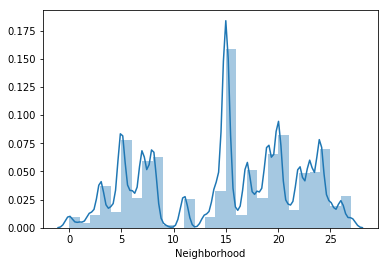

In [9]:
## Seperate by neighborhood:
import seaborn as sns
sns.distplot(X_2house['Neighborhood'], bins=27)

In [10]:
# get same neighborhood houses,
X_N15 = X_2house.loc[(X_2house['Neighborhood']==15) & (X_2house['Neighborhood_2']==15)]

In [11]:
X_N15_bol=[(X_2house['Neighborhood']==15) & (X_2house['Neighborhood_2']==15)]  
y_N15 = y_2house[X_N15_bol]

In [12]:
print(X_N15.shape)
print(y_N15.shape)

(97903, 158)
(97903,)


In [38]:
# make a function that does the stratifying of Neighborhood
def select_Neigh_df(df, y, code):
    """This function extracts the samples which belongs to a certian neighborhood"""
    """ Input is dataframe of X_2house comparison, target y array and code of the Neighborhood to be selected"""
    """ return dataframe X_N, corresponding selected y to X_N and the index of the corresponding house chosen(boolean of matching size to y)"""
    code = int(code)
    X_N = df.loc[(df['Neighborhood']==code) & (df['Neighborhood_2']==code)]
    X_N_bol=[(df['Neighborhood']==code) & (df['Neighborhood_2']==code)]  
    y_N = y[X_N_bol]
    return X_N, y_N, X_N_bol

In [41]:
pd.set_option('display.max_columns', None)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X_N15,y_N15,test_size=0.3,random_state=22)

In [14]:
## Do a model param setup
Lasso_m = Lasso()
Ridge_m = Ridge()
LR_m = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)

param_grid_Lasso = {'alpha': np.array([0.01, 0.05 ,0.1, 0.5, 5, 10, 15, 20, 25, 30, 50]), 'fit_intercept':[True], 'normalize':[True]}

mean -2612.64512834
standard deviation 45013.1994632


/NFS/home/home1/twang12/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


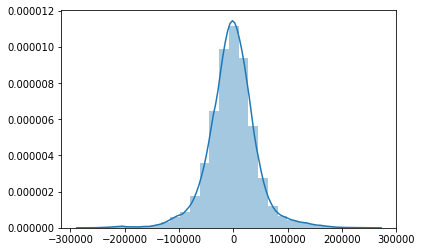

In [19]:
# scale the inputs :
sns.distplot(y_N15, bins= 30)
print("mean",np.mean(y_N15))
print("standard deviation", np.std(y_N15))
scal_y_N15= scale(y_N15)


mean 1.79988967109e-17
standard deviation 1.0


/NFS/home/home1/twang12/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


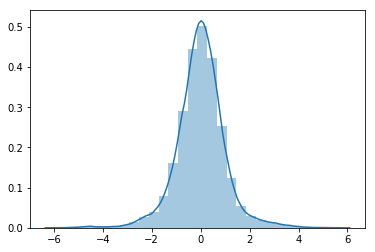

In [20]:
sns.distplot(scal_y_N15, bins= 30)
print("mean",np.mean(scal_y_N15))
print("standard deviation", np.std(scal_y_N15))

In [106]:
def model_fit(X_in, y_in, alpha_ary, alpha_ratio):
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split, KFold
    from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import scale
    from sklearn import metrics
    """ do 4 types of linear model fit with alpha to hypoparam test,  return result matrix"""
    """ Need to input full stratified X data and standardized, matching y """
    fit_intercept = True
    alpha, l1_ratio =.5,.5
    step_Lasso = Pipeline([('scaler',StandardScaler()),('Lasso', Lasso(alpha))]) ## Set up all the pipeline
    step_Ridge = Pipeline([('scaler',StandardScaler()),('Ridge', Ridge(alpha))])
    step_LR= Pipeline([('scaler',StandardScaler()), ('LR', LinearRegression(fit_intercept))])
    step_ELN= Pipeline([('scaler',StandardScaler()), ('ELN', ElasticNet(alpha,l1_ratio))])
        
    # Data prepare:(standardize y only)
    print("mean of prescale y:",np.mean(y_in))
    print("standard deviation of prescale y:", np.std(y_in))
    scal_y_in=scale(y_in)
   
    #set up dataframe for saving results
    
    df=pd.DataFrame(columns=['test#','model type','alpha','alpha_ratio','MSE_test','MSE_train','intercept','cv#'])
    coef_ind = ['test#']+list(X_in.columns)
    coef_df = pd.DataFrame(columns=coef_ind)

    test_no = 1 

    for i in range(len(alpha_ary)):
        alpha= alpha_ary[i]
        
        # divide data to 3 fold and do cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=22)
        cv_no=1
        for train_index, test_index in kf.split(X_in):
            X_train, X_test = X_in.iloc[train_index], X_in.iloc[test_index]
            y_train, y_test = scal_y_in[train_index], scal_y_in[test_index]
            # do fitting and predcition
            #(1) Lasso
            print("cv of Lasso.....", cv_no)
            step_Lasso.fit(X_train,y_train)
            y_test_pred = step_Lasso.predict(X_test)
            y_train_pred = step_Lasso.predict(X_train)
            MSE_test = metrics.mean_squared_error(y_test, y_test_pred)
            MSE_train = metrics.mean_squared_error(y_train, y_train_pred)
            tmp_wrt = [test_no, 'Lasso', alpha, 'NAN', MSE_test, MSE_train, step_Lasso.steps[1][1].intercept_, cv_no]
            df.loc[len(df)]=tmp_wrt
            
            tmp_wrt2 = [test_no]+list(step_Lasso.steps[1][1].coef_)
            coef_df.loc[len(coef_df)]=tmp_wrt2
            
            # re calculate 
            test_no+=1
            
            #(2) Ridge
            print("cv of Ridge.....", cv_no)
            step_Ridge.fit(X_train,y_train)
            y_test_pred = step_Ridge.predict(X_test)
            y_train_pred = step_Ridge.predict(X_train)
            MSE_test = metrics.mean_squared_error(y_test, y_test_pred)
            MSE_train = metrics.mean_squared_error(y_train, y_train_pred)
            tmp_wrt = [test_no, 'Ridge', alpha, 'NAN', MSE_test, MSE_train, step_Ridge.steps[1][1].intercept_, cv_no]
            df.loc[len(df)]=tmp_wrt
            
            tmp_wrt2 = [test_no]+list(step_Ridge.steps[1][1].coef_)
            coef_df.loc[len(coef_df)]=tmp_wrt2
             
            # re calculate             
            test_no+=1
            
            #(3) Linear Regression
            print("cv of LR.....", cv_no)
            step_LR.fit(X_train,y_train)
            y_test_pred = step_LR.predict(X_test)
            y_train_pred = step_LR.predict(X_train)
            MSE_test = metrics.mean_squared_error(y_test, y_test_pred)
            MSE_train = metrics.mean_squared_error(y_train, y_train_pred)
            tmp_wrt = [test_no, 'LR', 'NAN', 'NAN', MSE_test, MSE_train, step_LR.steps[1][1].intercept_, cv_no]
            df.loc[len(df)]=tmp_wrt
            
            tmp_wrt2 = [test_no]+list(step_LR.steps[1][1].coef_)
            coef_df.loc[len(coef_df)]=tmp_wrt2
             
            # re calculate             
            test_no+=1            

            #(4) Elastic Net
            print("cv of Elastic Net.....", cv_no)
            for j in range(len(alpha_ratio)):
                l1_ratio = alpha_ratio[j]
                step_ELN.fit(X_train,y_train)
                y_test_pred = step_ELN.predict(X_test)
                y_train_pred = step_ELN.predict(X_train)
                MSE_test = metrics.mean_squared_error(y_test, y_test_pred)
                MSE_train = metrics.mean_squared_error(y_train, y_train_pred)
                tmp_wrt = [test_no, 'ElasticNet', alpha, l1_ratio, MSE_test, MSE_train, step_ELN.steps[1][1].intercept_, cv_no]
                df.loc[len(df)]=tmp_wrt
            
                tmp_wrt2 = [test_no]+list(step_ELN.steps[1][1].coef_)
                coef_df.loc[len(coef_df)]=tmp_wrt2
             
                # re calculate             
                test_no+=1  
            cv_no+=1
            
    p=StandardScaler()
    p.fit(X_in)        
    X_mean = p.mean_
    X_std = np.sqrt(p.var_)

    return df, coef_df, X_mean, X_std

In [146]:
df, coef_df,  X_N15_mean, X_N15_std = model_fit(X_N15,y_N15,[0.05,0.1,0.5,5,10,15],[0.1,0.3,0.5,0.7])

mean of prescale y: -2612.64512834
standard deviation of prescale y: 45013.1994632
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..

In [114]:
df.to_csv('Strat_N15_All_LinMod_results.csv', index = False)

In [120]:
coef_df.to_csv('Strat_N15_All_LinMod_coefs.csv', index = False)

In [149]:
np.save('X_N15_mean.npz',X_N15_mean)
np.save('X_N15_std.npz',X_N15_std)

In [121]:
s =df.loc[df['model type']=='Lasso']['test#']

In [110]:
df.sort_values(by=['MSE_test'])

,test#,model type,alpha,alpha_ratio,MSE_test,MSE_train,intercept,cv#
1,2,Ridge,0.05,NAN,0.118816,0.120817,-0.003217,1
64,65,Ridge,5,NAN,0.118816,0.120817,-0.003217,1
106,107,Ridge,15,NAN,0.118816,0.120817,-0.003217,1
43,44,Ridge,0.5,NAN,0.118816,0.120817,-0.003217,1
22,23,Ridge,0.1,NAN,0.118816,0.120817,-0.003217,1
85,86,Ridge,10,NAN,0.118816,0.120817,-0.003217,1
2,3,LR,NAN,NAN,0.118820,0.120825,-0.003301,1
65,66,LR,NAN,NAN,0.118820,0.120825,-0.003301,1
23,24,LR,NAN,NAN,0.118820,0.120825,-0.003301,1
107,108,LR,NAN,NAN,0.118820,0.120825,-0.003301,1


In [124]:
# Fit the final linear model
fin_mod=Ridge(alpha = 0.1, fit_intercept = True, normalize = False)
sc=StandardScaler()
scal_X_N15=sc.fit_transform(X_N15)
fin_mod.fit(scal_X_N15,scal_y_N15)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [133]:
y_pred=fin_mod.predict(scal_X_N15)
MSEscore= metrics.mean_squared_error(scal_y_N15, y_pred)
print("MSE Score:", MSEscore)

MSE Score: 0.120045210398


In [167]:
# test on other Neighborhood data
X_N5, y_N5, X_N5_bol = select_Neigh_df(X_2house, y_2house,5)
print(X_N5.shape)

(35511, 158)


In [168]:
df, coef_df,  X_N5_mean, X_N5_std = model_fit(X_N5,y_N5,[0.05,0.1,0.5,5,10,15],[0.1,0.3,0.5,0.7])

mean of prescale y: -3249.75506181
standard deviation of prescale y: 76564.2469586
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..

In [169]:
df.to_csv('Strat_N5_All_LinMod_results.csv', index = False)

In [170]:
coef_df.to_csv('Strat_N5_All_LinMod_coefs.csv', index = False)

In [171]:
np.save('X_N5_mean.npz',X_N5_mean)
np.save('X_N5_std.npz',X_N5_std)

In [145]:
# test on other Neighborhood data
X_N20, y_N20, X_N20_bol = select_Neigh_df(X_2house, y_2house,20)
print(X_N20.shape)

(28441, 158)


In [150]:
df, coef_df,  X_N20_mean, X_N20_std = model_fit(X_N20,y_N20,[0.05,0.1,0.5,5,10,15],[0.1,0.3,0.5,0.7])

mean of prescale y: 5238.49709926
standard deviation of prescale y: 62468.7323907
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR...

In [151]:
df.to_csv('Strat_N20_All_LinMod_results.csv', index = False)

In [152]:
coef_df.to_csv('Strat_N20_All_LinMod_coefs.csv', index = False)

In [153]:
np.save('X_N20_mean.npz',X_N20_mean)
np.save('X_N20_std.npz',X_N20_std)

In [155]:
df.sort_values(by=['MSE_test'])

,test#,model type,alpha,alpha_ratio,MSE_test,MSE_train,intercept,cv#
15,16,Ridge,0.05,NAN,0.065155,0.065351,-0.002797,3
78,79,Ridge,5,NAN,0.065155,0.065351,-0.002797,3
57,58,Ridge,0.5,NAN,0.065155,0.065351,-0.002797,3
36,37,Ridge,0.1,NAN,0.065155,0.065351,-0.002797,3
99,100,Ridge,10,NAN,0.065155,0.065351,-0.002797,3
120,121,Ridge,15,NAN,0.065155,0.065351,-0.002797,3
100,101,LR,NAN,NAN,0.065159,0.065356,-0.002825,3
37,38,LR,NAN,NAN,0.065159,0.065356,-0.002825,3
16,17,LR,NAN,NAN,0.065159,0.065356,-0.002825,3
79,80,LR,NAN,NAN,0.065159,0.065356,-0.002825,3


In [159]:
# Try randomize a selection of 100000 samples out of original data, and test the same cv procedure
from random import sample

# create random index
rindex =  np.array(sample(range(len(X_2house)), 100000))

# get 100000 random rows from df
X_randN = X_2house.iloc[rindex]
y_rand = y_2house[rindex]

In [160]:
X_randN.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,MS SubClass_2,MS Zoning_2,Lot Frontage_2,Lot Area_2,Street_2,Alley_2,Lot Shape_2,Land Contour_2,Utilities_2,Lot Config_2,Land Slope_2,Neighborhood_2,Condition 1_2,Condition 2_2,Bldg Type_2,House Style_2,Overall Qual_2,Overall Cond_2,Year Built_2,Year Remod/Add_2,Roof Style_2,Roof Matl_2,Exterior 1st_2,Exterior 2nd_2,Mas Vnr Type_2,Mas Vnr Area_2,Exter Qual_2,Exter Cond_2,Foundation_2,Bsmt Qual_2,Bsmt Cond_2,Bsmt Exposure_2,BsmtFin Type 1_2,BsmtFin SF 1_2,BsmtFin Type 2_2,BsmtFin SF 2_2,Bsmt Unf SF_2,Total Bsmt SF_2,Heating_2,Heating QC_2,Central Air_2,Electrical_2,1st Flr SF_2,2nd Flr SF_2,Low Qual Fin SF_2,Gr Liv Area_2,Bsmt Full Bath_2,Bsmt Half Bath_2,Full Bath_2,Half Bath_2,Bedroom AbvGr_2,Kitchen AbvGr_2,Kitchen Qual_2,TotRms AbvGrd_2,Functional_2,Fireplaces_2,Fireplace Qu_2,Garage Type_2,Garage Yr Blt_2,Garage Finish_2,Garage Cars_2,Garage Area_2,Garage Qual_2,Garage Cond_2,Paved Drive_2,Wood Deck SF_2,Open Porch SF_2,Enclosed Porch_2,3Ssn Porch_2,Screen Porch_2,Pool Area_2,Pool QC_2,Fence_2,Misc Feature_2,Misc Val_2,Mo Sold_2,Yr Sold_2,Sale Type_2,Sale Condition_2
Order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3156145,80.0,4.0,85.0,10541.0,1.0,1.0,0.0,3.0,4.0,0.0,2.0,23.0,2.0,2.0,0.0,1.0,7.0,5.0,1996.0,1996.0,1.0,1.0,13.0,14.0,3.0,0.0,4.0,3.0,2.0,4.0,3.0,3.0,1.0,0.0,1.0,0.0,672.0,672.0,1.0,5.0,1.0,5.0,1302.0,735.0,0.0,2037.0,0.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,1.0,3.0,1.0,1996.0,3.0,2.0,472.0,3.0,3.0,2.0,100.0,33.0,0.0,0.0,0.0,0.0,-1.0,4.0,0.0,0.0,2.0,2008.0,0.0,3.0,30.0,4.0,80.0,11600.0,1.0,1.0,3.0,3.0,4.0,4.0,2.0,6.0,2.0,2.0,0.0,1.0,4.0,5.0,1922.0,1950.0,1.0,1.0,8.0,8.0,3.0,0.0,3.0,3.0,0.0,2.0,3.0,-1.0,1.0,0.0,1.0,0.0,700.0,700.0,1.0,5.0,1.0,5.0,1180.0,0.0,0.0,1180.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,5.0,7.0,1.0,4.0,5.0,1922.0,1.0,1.0,252.0,3.0,2.0,2.0,0.0,0.0,67.0,0.0,0.0,0.0,-1.0,4.0,0.0,0.0,7.0,2006.0,0.0,3.0
1311214,60.0,4.0,42.0,8433.0,1.0,1.0,0.0,3.0,4.0,4.0,2.0,8.0,2.0,2.0,0.0,2.0,6.0,5.0,2000.0,2000.0,1.0,1.0,13.0,14.0,3.0,0.0,3.0,3.0,2.0,4.0,3.0,-1.0,6.0,683.0,1.0,0.0,111.0,794.0,1.0,5.0,1.0,5.0,819.0,695.0,0.0,1514.0,1.0,0.0,2.0,1.0,3.0,1.0,3.0,7.0,7.0,1.0,3.0,1.0,2000.0,3.0,2.0,394.0,3.0,3.0,2.0,0.0,72.0,0.0,0.0,0.0,0.0,-1.0,4.0,0.0,0.0,6.0,2009.0,0.0,3.0,120.0,4.0,22.0,11064.0,1.0,1.0,1.0,3.0,4.0,1.0,2.0,27.0,2.0,2.0,4.0,1.0,8.0,5.0,1995.0,1995.0,3.0,1.0,3.0,3.0,3.0,0.0,4.0,3.0,2.0,4.0,3.0,4.0,2.0,560.0,6.0,670.0,0.0,1230.0,1.0,5.0,1.0,5.0,1239.0,0.0,0.0,1239.0,1.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0,7.0,1.0,2.0,1.0,1995.0,3.0,2.0,477.0,3.0,3.0,2.0,172.0,24.0,0.0,0.0,0.0,0.0,-1.0,4.0,0.0,0.0,8.0,2008.0,0.0,3.0
3877360,50.0,6.0,52.0,6240.0,1.0,1.0,3.0,3.0,4.0,4.0,2.0,3.0,2.0,2.0,0.0,1.7,6.0,6.0,1931.0,1950.0,1.0,1.0,14.0,15.0,3.0,0.0,3.0,3.0,0.0,3.0,2.0,-1.0,2.0,425.0,1.0,0.0,459.0,884.0,1.0,3.0,1.0,4.0,959.0,408.0,0.0,1367.0,0.0,0.0,1.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,4.0,5.0,1978.0,1.0,1.0,560.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,120.0,0.0,-1.0,4.0,0.0,0.0,11.0,2007.0,0.0,3.0,20.0,4.0,95.0,13618.0,1.0,

In [161]:
df, coef_df,  X_rand_mean, X_rand_std = model_fit(X_randN,y_rand,[0.05,0.1,0.5,5,10,15],[0.1,0.3,0.5,0.7])

mean of prescale y: -3765.10704
standard deviation of prescale y: 113058.314481
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR..... 3
cv of Elastic Net..... 3
cv of Lasso..... 1
cv of Ridge..... 1
cv of LR..... 1
cv of Elastic Net..... 1
cv of Lasso..... 2
cv of Ridge..... 2
cv of LR..... 2
cv of Elastic Net..... 2
cv of Lasso..... 3
cv of Ridge..... 3
cv of LR.....

In [162]:
df.to_csv('Strat_rand100k_All_LinMod_results.csv', index = False)

In [163]:
coef_df.to_csv('Strat_rand100k_All_LinMod_coefs.csv', index = False)

In [164]:
np.save('X_rand100k_mean.npz',X_rand_mean)
np.save('X_rand100k_std.npz',X_rand_std)

In [165]:
df.sort_values(by=['MSE_test'])

,test#,model type,alpha,alpha_ratio,MSE_test,MSE_train,intercept,cv#
37,38,LR,NAN,NAN,0.128425,0.133650,-0.001867,3
58,59,LR,NAN,NAN,0.128425,0.133650,-0.001867,3
121,122,LR,NAN,NAN,0.128425,0.133650,-0.001867,3
100,101,LR,NAN,NAN,0.128425,0.133650,-0.001867,3
79,80,LR,NAN,NAN,0.128425,0.133650,-0.001867,3
16,17,LR,NAN,NAN,0.128425,0.133650,-0.001867,3
57,58,Ridge,0.5,NAN,0.128426,0.133650,-0.001881,3
120,121,Ridge,15,NAN,0.128426,0.133650,-0.001881,3
99,100,Ridge,10,NAN,0.128426,0.133650,-0.001881,3
78,79,Ridge,5,NAN,0.128426,0.133650,-0.001881,3


In [166]:
coef_df.head()

,test#,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,MS SubClass_2,MS Zoning_2,Lot Frontage_2,Lot Area_2,Street_2,Alley_2,Lot Shape_2,Land Contour_2,Utilities_2,Lot Config_2,Land Slope_2,Neighborhood_2,Condition 1_2,Condition 2_2,Bldg Type_2,House Style_2,Overall Qual_2,Overall Cond_2,Year Built_2,Year Remod/Add_2,Roof Style_2,Roof Matl_2,Exterior 1st_2,Exterior 2nd_2,Mas Vnr Type_2,Mas Vnr Area_2,Exter Qual_2,Exter Cond_2,Foundation_2,Bsmt Qual_2,Bsmt Cond_2,Bsmt Exposure_2,BsmtFin Type 1_2,BsmtFin SF 1_2,BsmtFin Type 2_2,BsmtFin SF 2_2,Bsmt Unf SF_2,Total Bsmt SF_2,Heating_2,Heating QC_2,Central Air_2,Electrical_2,1st Flr SF_2,2nd Flr SF_2,Low Qual Fin SF_2,Gr Liv Area_2,Bsmt Full Bath_2,Bsmt Half Bath_2,Full Bath_2,Half Bath_2,Bedroom AbvGr_2,Kitchen AbvGr_2,Kitchen Qual_2,TotRms AbvGrd_2,Functional_2,Fireplaces_2,Fireplace Qu_2,Garage Type_2,Garage Yr Blt_2,Garage Finish_2,Garage Cars_2,Garage Area_2,Garage Qual_2,Garage Cond_2,Paved Drive_2,Wood Deck SF_2,Open Porch SF_2,Enclosed Porch_2,3Ssn Porch_2,Screen Porch_2,Pool Area_2,Pool QC_2,Fence_2,Misc Feature_2,Misc Val_2,Mo Sold_2,Yr Sold_2,Sale Type_2,Sale Condition_2
0,1.0,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.070447,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00,-0.000000,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.055316,-0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000
1,2.0,0.042626,0.017422,-0.013710,-0.028666,-0.005638,-0.002320,0.005229,-0.002683,-0.008645,0.000213,0.004319,-0.009181,0.002550,-0.006505,0.013920,0.027658,-0.135735,-0.056103,-0.069763,0.003111,-0.016150,-0.004736,0.006656,0.006103,-0.045281,-0.066339,-0.063241,0.006803,-0.007725,-0.060728,0.053854,-0.036860,-0.001073,-5.983526e-02,-0.000497,-9.581431e-03,8.091307e-03,-5.727642e-02,0.003163,-0.014276